In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

In [5]:
import statsmodels.api as sm

def ols_fit(data,y):
    '''
    Calculate OLS fit of a line aking use of statsmodels.api
    
    Parameters:
    ----------
        data: exog of line
        y: endog of line
    
    Returns:
    -------
        p: fit params with constant first
    '''
    
    # fit model
    model = data.T
    model = sm.add_constant(model)
    model_fit = sm.OLS(y,model).fit()
    print(model_fit.summary())
    p = model_fit.params
    return p

In [6]:
parsec.columns

<TableColumns names=('Zini','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

In [9]:
carrera = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Zini']/0.02),parsec['logg'],
                    parsec['logTe']**2, np.log10(parsec['Zini']/0.02)**2,parsec['logTe']**3])
p = ols_fit(carrera,parsec['logAge'])

def carrera_ages(lt,k,feh,lg):
    return p[0]+p[1]*lt+p[2]*k+p[3]*feh+p[4]*lg+p[5]*lt**2+p[6]*feh**2+p[7]*lt**3

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 4.129e+05
Date:                Mon, 06 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:38:14   Log-Likelihood:                 28703.
No. Observations:               16121   AIC:                        -5.739e+04
Df Residuals:                   16113   BIC:                        -5.733e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1753.1119     91.654     19.127      0.0

In [35]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE']+r13['FE_H']-r13['M_H']))
    x_N.append(sol_xm[1]*10**(r13['N_FE']+r13['FE_H']-r13['M_H']))
    x_O.append(sol_xm[2]*10**(r13['O_FE']+r13['FE_H']-r13['M_H']))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE']+r13['FE_H']-r13['M_H']))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE']+r13['FE_H']-r13['M_H']))
    x_S.append(sol_xm[5]*10**(r13['S_FE']+r13['FE_H']-r13['M_H']))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE']+r13['FE_H']-r13['M_H']))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H']-r13['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

_, _, stardist = afunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = afunc.absmag(r13['K'],stardist)-r13['AK_TARG']
c_ages = carrera_ages(np.log10(r13['TEFF']),corabsK,afunc.sal(r13['M_H'],metscorr),r13['LOGG'])

In [22]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [37]:
#######################################
### Get Uncertainties: Random Error ###
#######################################

randdevs = []

for i in tqdm_notebook(range(len(r13)),desc='Done?',leave=False):
    lgT = np.log10(r13['TEFF'][i])
    lgTERR = 0.434*(np.log(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
    ks = corabsK[i]
    ksERR = r13['K_ERR'][i]
    mh = r13['M_H'][i]
    mhERR = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfeERR = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfeERR = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    fehERR = r13['FE_H_ERR'][i]
    lgg = r13['LOGG'][i]
    lggERR = r13['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(carrera_ages(nlgT,nks,afunc.sal(nmh,nfac),nlgg))
    
    randdevs.append(afunc.mad(ages))

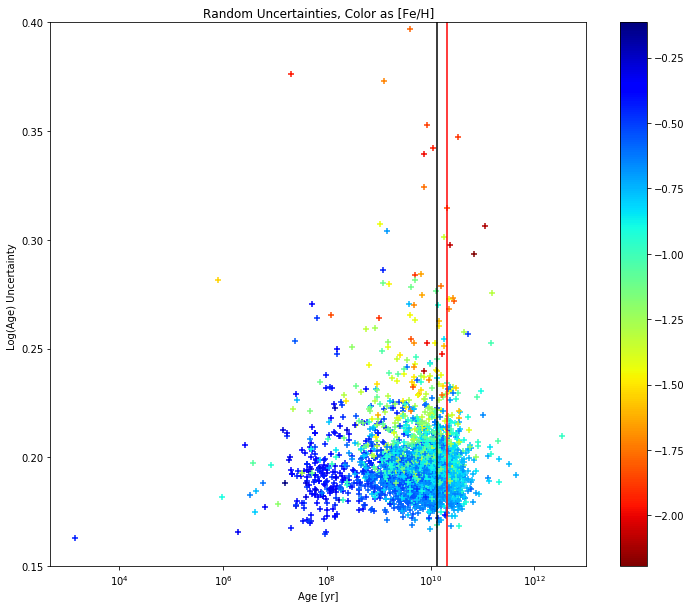

In [61]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(c_ages),randdevs,marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.median(randdevs)),c='r')
plt.axvline(10**(np.log10(ageU)),c='k')
plt.xscale('log')
plt.ylim(0.15,0.4)
plt.title(r'Random Uncertainties, Color as [Fe/H]')
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty ')
plt.show()

In [64]:
len(np.squeeze(np.where(c_ages>np.log10(ageU)+np.median(randdevs))))/len(c_ages)

0.16267387944358577

In [59]:
10**(c_ages[np.asarray(randdevs).argmin()]+randdevs[np.asarray(randdevs).argmin()])

2011.2853155656621